### Algorithm 1. -> filtering and simple thresholding

From the initial inspection of the data, it can be seen that there are certain frequency components in the data that are a constant noise. In row 2 it is the 60Hz noise, and from row 3 to row 5 it becomes increasingly complex. So, it is important to understand that we need to filter out some frequency components.

I see that the frequency range of neural spikes is somewhere between 450Hz to 6.5KHz. The first step in the spike detection task is hence bandpass filtering our signal between 450Hz to 6.5KHz.

Research paper referenced before proceeding with this step:

`Obeid, Iyad, and Patrick D. Wolf. "Evaluation of spike-detection algorithms fora brain-machine interface application." IEEE Transactions on Biomedical Engineering 51.6 (2004): 905-911.`


In [1]:
## imports for the required modules

import sys
import math
import numpy as np

## for signal processing applications
from scipy.signal import butter, sosfiltfilt, filtfilt, sosfreqz
from scipy.fft import fft, fftfreq

## For plotting signals
import matplotlib.pyplot as plt
%matplotlib inline

#### Create a bandpass filter

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b = butter(order, [low, high], btype='band', output='sos')
    return b

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b= butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(b, data)
    return y

#### Generate the frequency response of bandpass filter

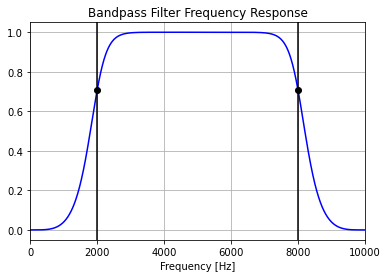

In [3]:
low = 2000
high = 8000
fs = 20000 ## given in the problem statement
order = 4

# Get the filter coefficients so we can check its frequency response.
sos = butter_bandpass(low, high, fs, order)

# Plot the frequency response.
w, h = sosfreqz(sos, fs=fs, worN=8000)
plt.plot(w, np.abs(h), 'b')
plt.plot(low, 0.5*np.sqrt(2), 'ko')
plt.plot(high, 0.5*np.sqrt(2), 'ko')
plt.axvline(high, color='k')
plt.axvline(low, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Bandpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

Now that we are ready with the filter, we read the data and start our processing

In [4]:
csv_file = "./data/example_data.csv"
row_to_plot = 5 ## 1->5

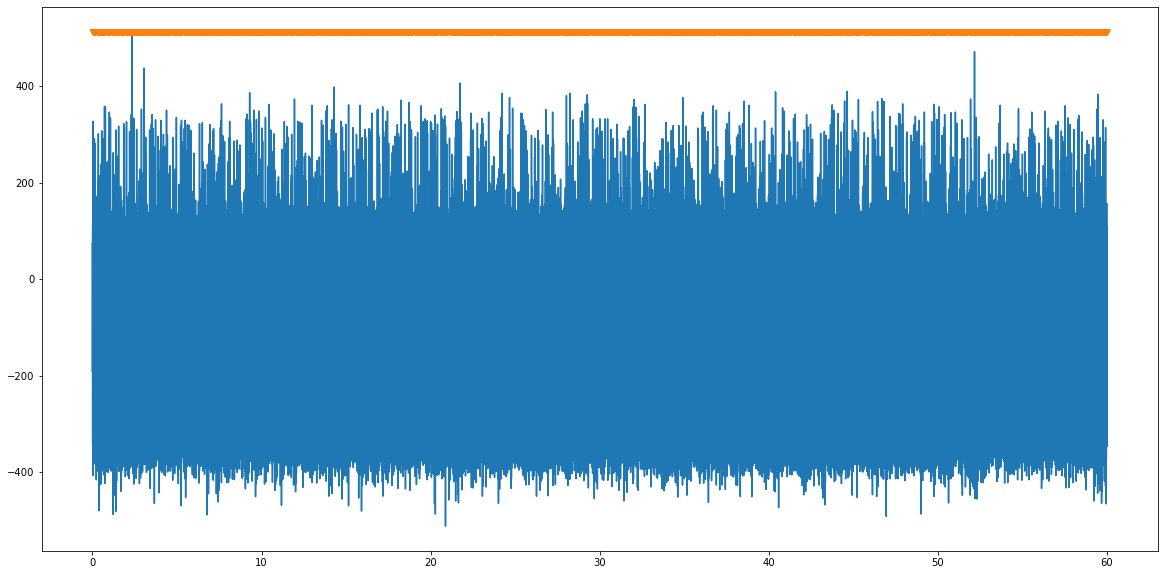

In [5]:
## taken from the script visualize_signal.py

plt.rcParams["figure.figsize"] = [20, 10]

with open(csv_file, 'r') as f:
    original_data = f.read().split('\n')[1:]
    original_data = original_data[row_to_plot].split(',')
    spike_positions = [int(x) for x in original_data[1].split(';')]
    samples = [int(x) for x in original_data[0].split(';')]

spikes = [math.nan] * len(samples)

# Plot spike indicators above all samples.
spike_y = max(samples) + 1

# Replace the values in the positions of the spikes with the maximum sample value
for s in spike_positions:
    spikes[s] = spike_y

# Generate the time vector (fs=20kHz)
t = [x/20000 for x in range(len(samples))]

plt.plot(t, samples)
plt.plot(t, spikes, 'v')
plt.show()

#### Filtering the signal in the range 450Hz to 6.5KHz

In [6]:
filtered = butter_bandpass_filter(samples, 450, 6000, 20000, order=8) 
## We can try multiple orders for the filter

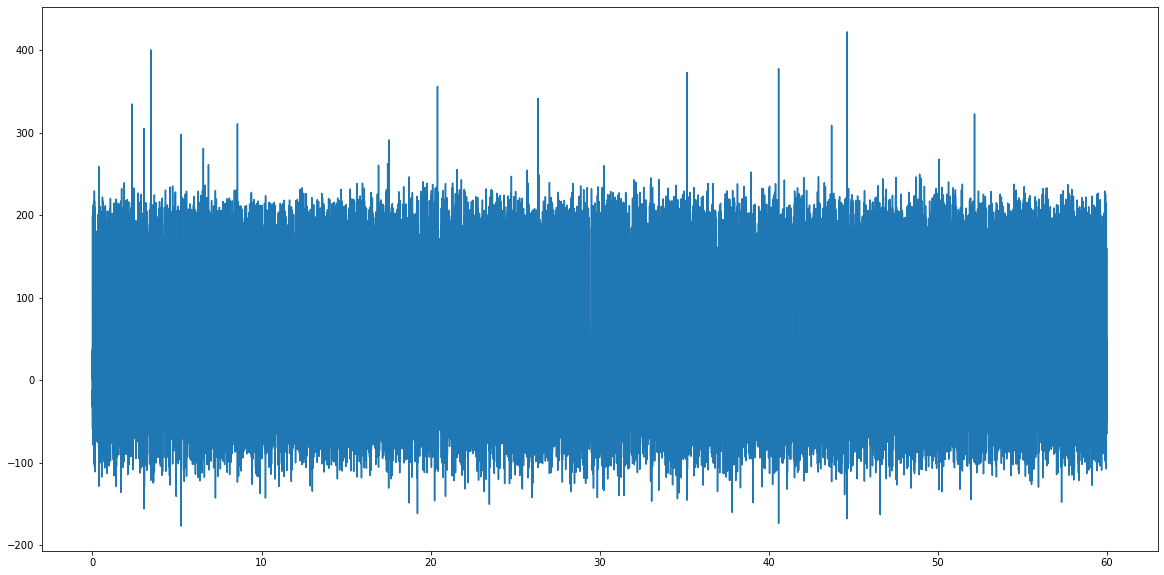

In [7]:
plt.plot(t, filtered)
plt.show()

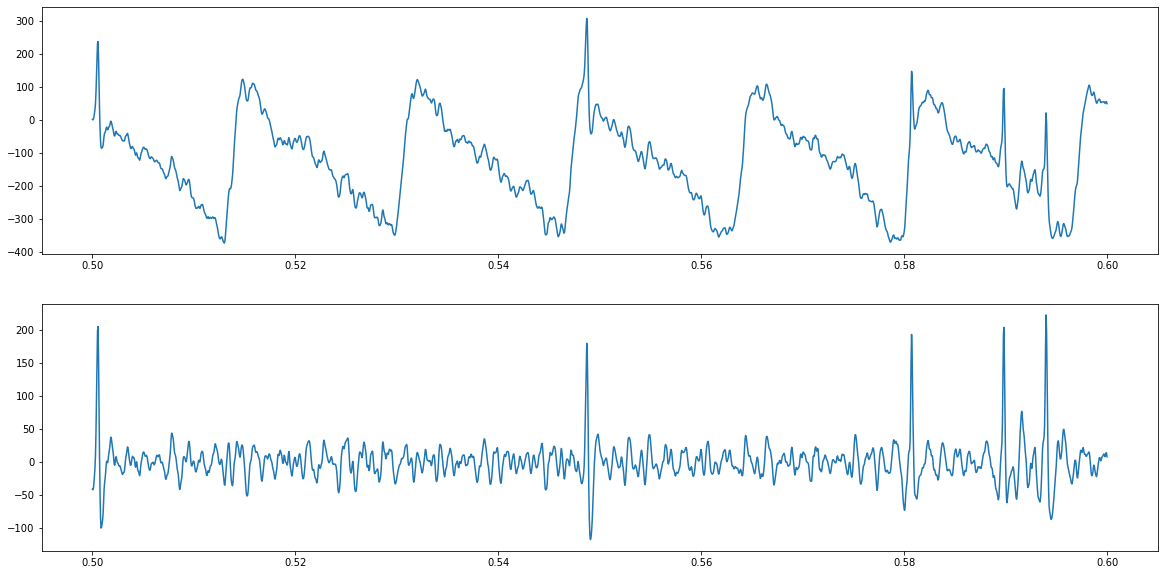

In [8]:
plt.subplot(2,1,1)
plt.plot(t[10000:12000], samples[10000:12000])
plt.subplot(2,1,2)
plt.plot(t[10000:12000], filtered[10000:12000])
plt.show()

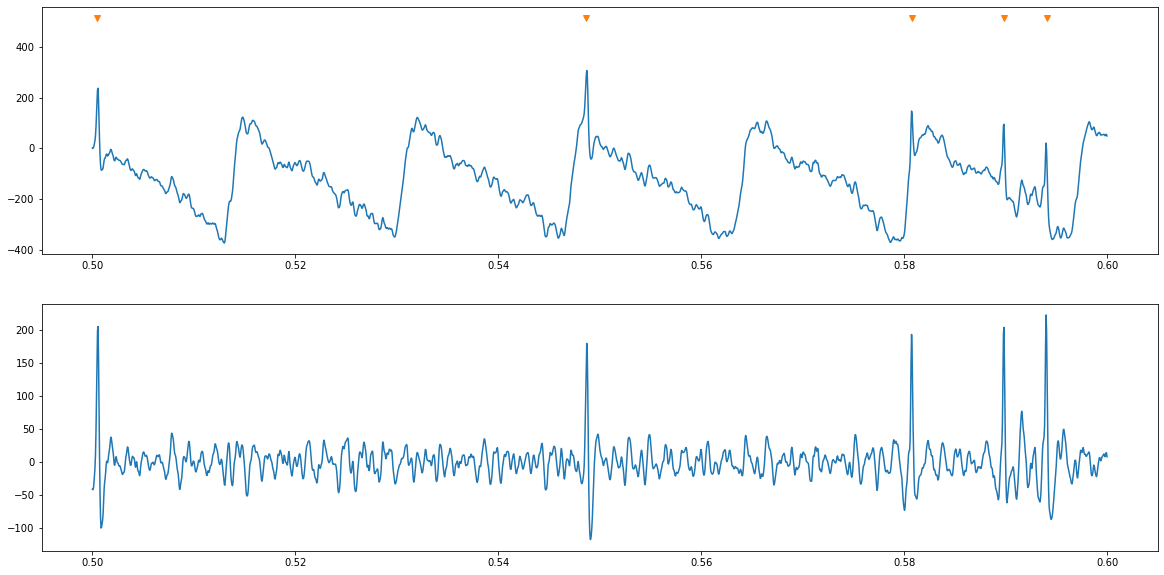

In [9]:
plt.subplot(2,1,1)
plt.plot(t[10000:12000], samples[10000:12000])
plt.plot(t[10000:12000], spikes[10000:12000], 'v')
plt.subplot(2,1,2)
plt.plot(t[10000:12000], filtered[10000:12000])
plt.show()

#### We can see how the noise has been cleaned out to a good extent from the signal

#### Next step is to detect the spikes. For this, we will have to find the mean and std deviation of the signal and look at the formula: 

$$
threshold = N*\sigma
$$
$$
\sigma = median(|x-\bar x|/0.6745)
$$

For starting, we can choose N = 7

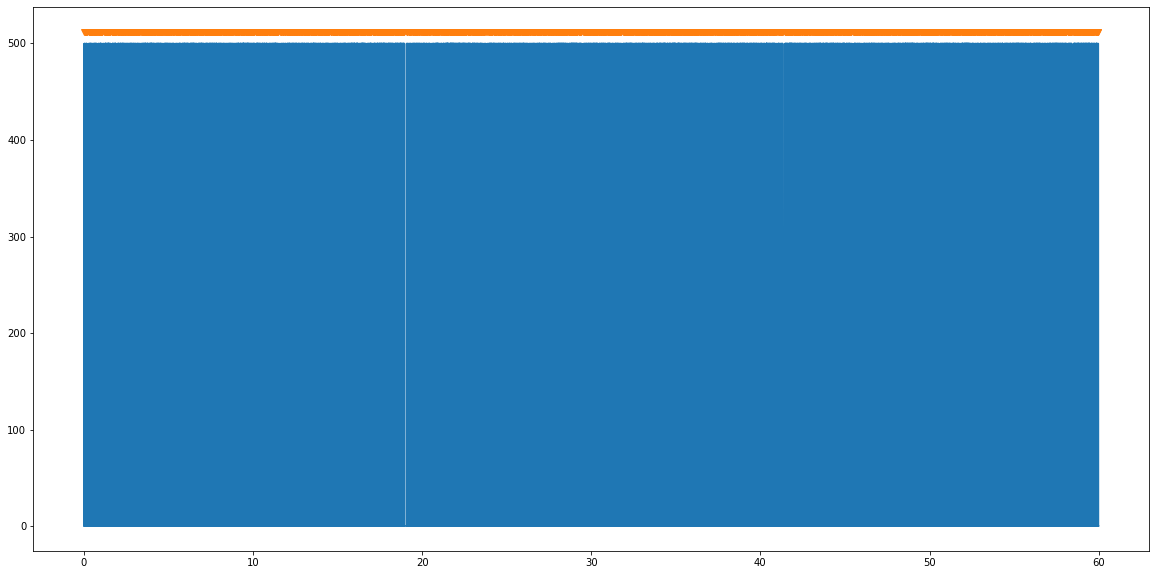

In [10]:
N = 3
mean = np.mean(filtered)
spiked = np.zeros(len(filtered))
sigma =np.median(np.abs(filtered-mean)/0.6745)
spiked[filtered>N*sigma] = 1
plt.plot(t, spiked*500)
plt.plot(t, spikes, "v")

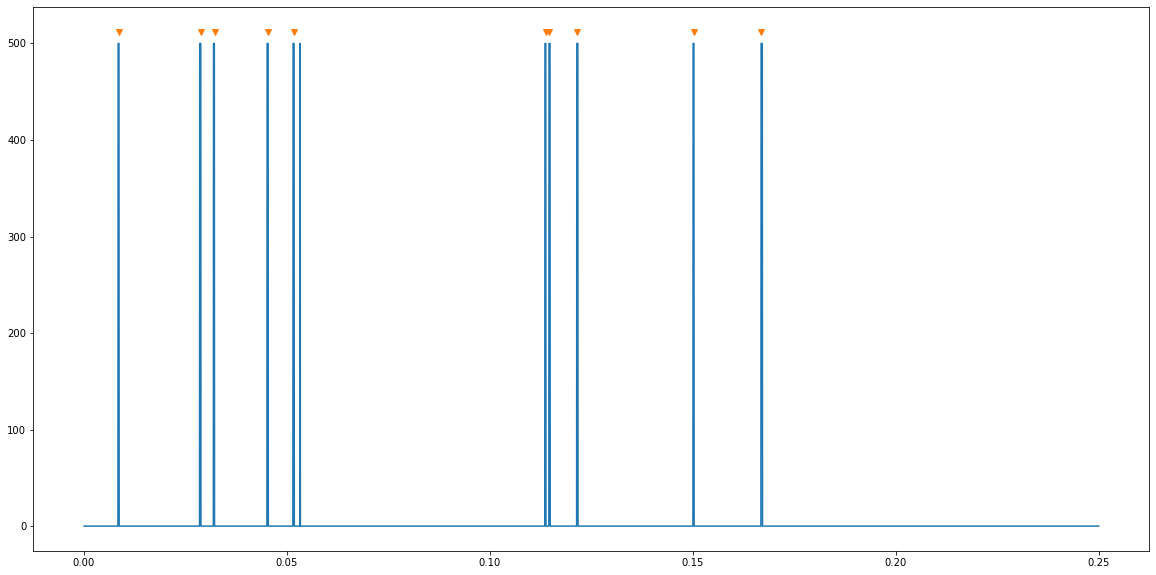

In [11]:
plt.plot(t[:5000], spiked[:5000]*500)
plt.plot(t[:5000], spikes[:5000], "v")

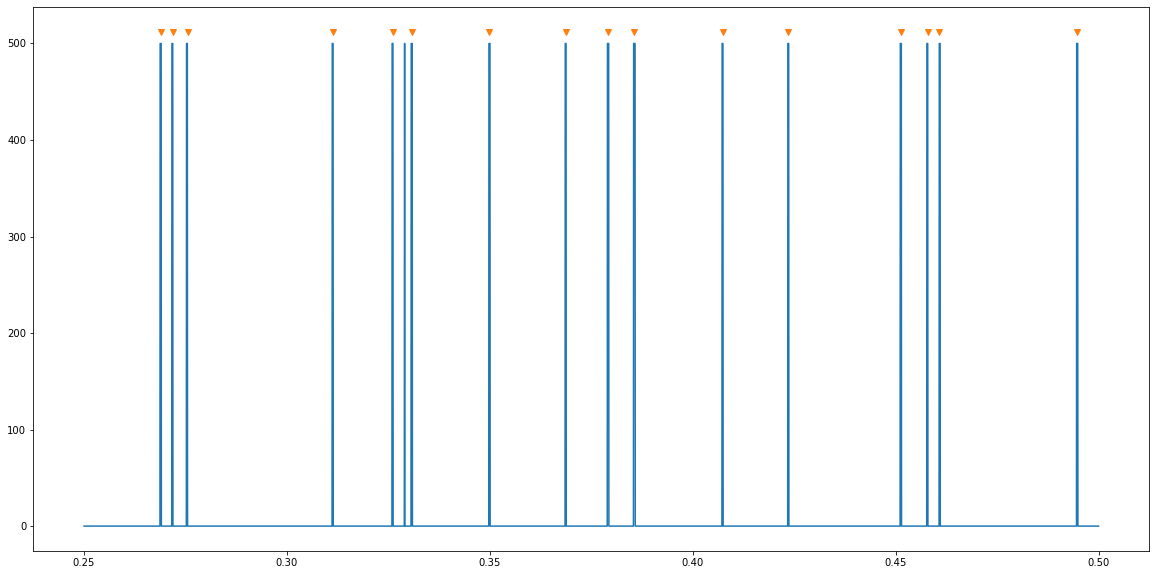

In [12]:
plt.plot(t[5000:10000], spiked[5000:10000]*500)
plt.plot(t[5000:10000], spikes[5000:10000], "v")

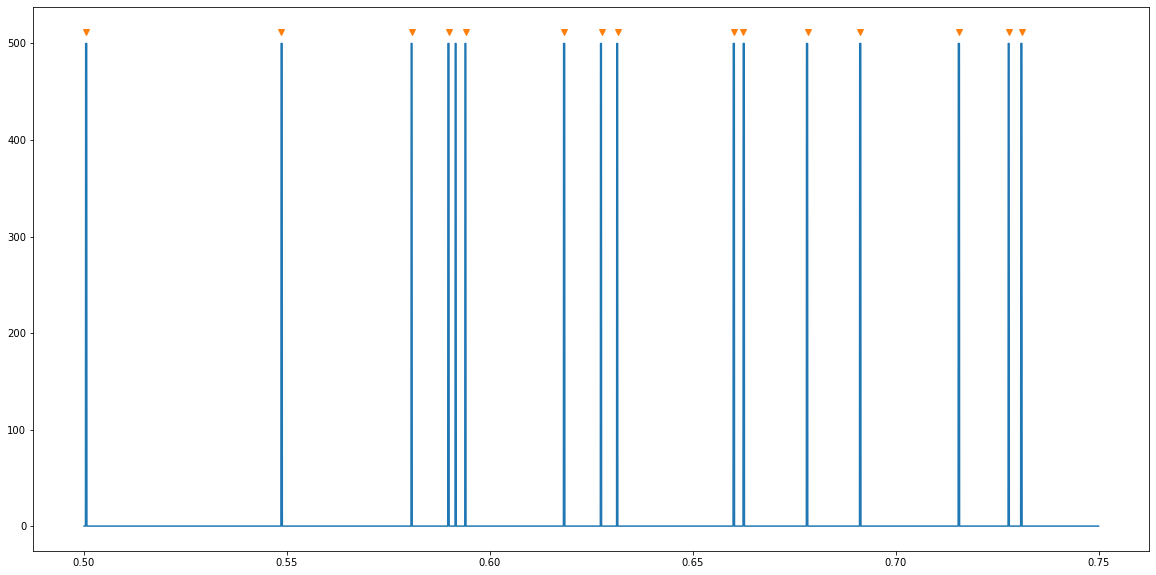

In [13]:
plt.plot(t[10000:15000], spiked[10000:15000]*500)
plt.plot(t[10000:15000], spikes[10000:15000], "v")

#### From visual inspection, it looks like we are detecting the spikes well. So, we bechmark the performance of our algorithm

#### To do this, we loop over all the 5 rows and find the accuracy

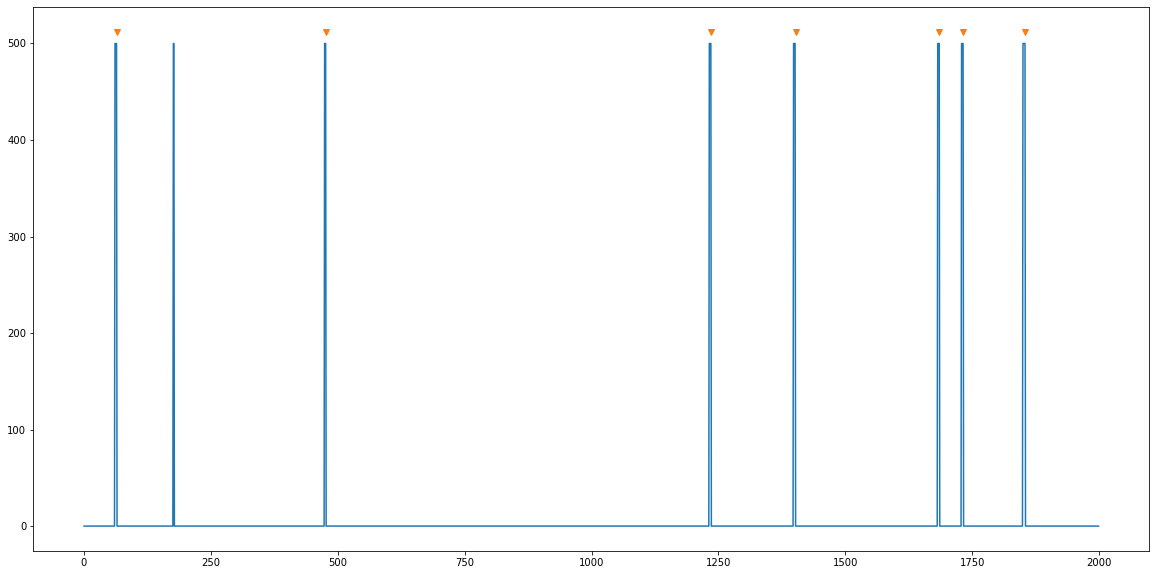

Accuracy for row  1  is  99.484 %


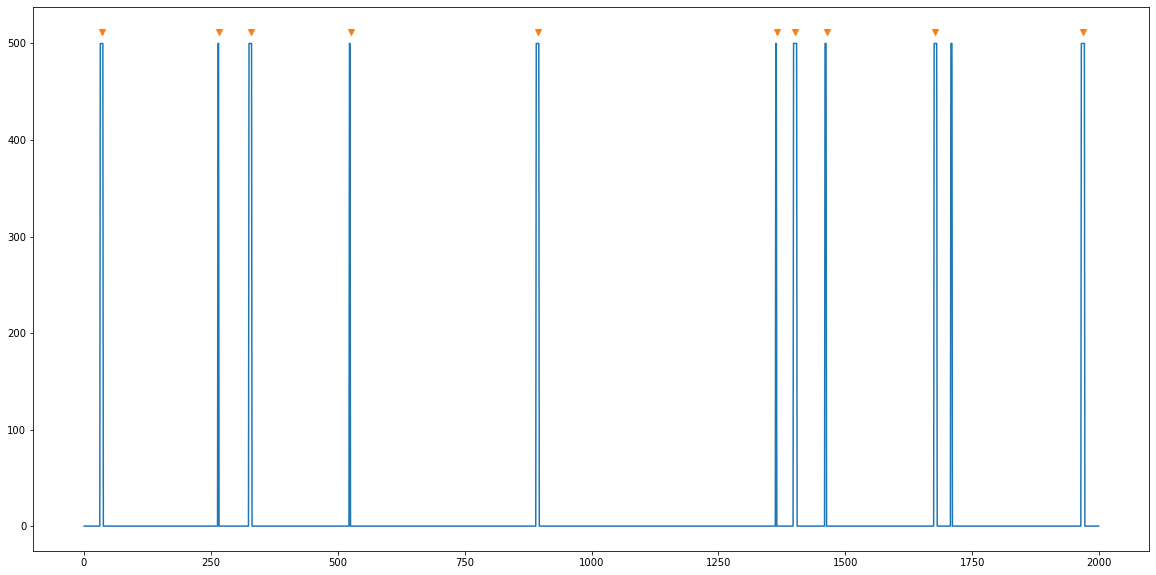

Accuracy for row  2  is  99.375 %


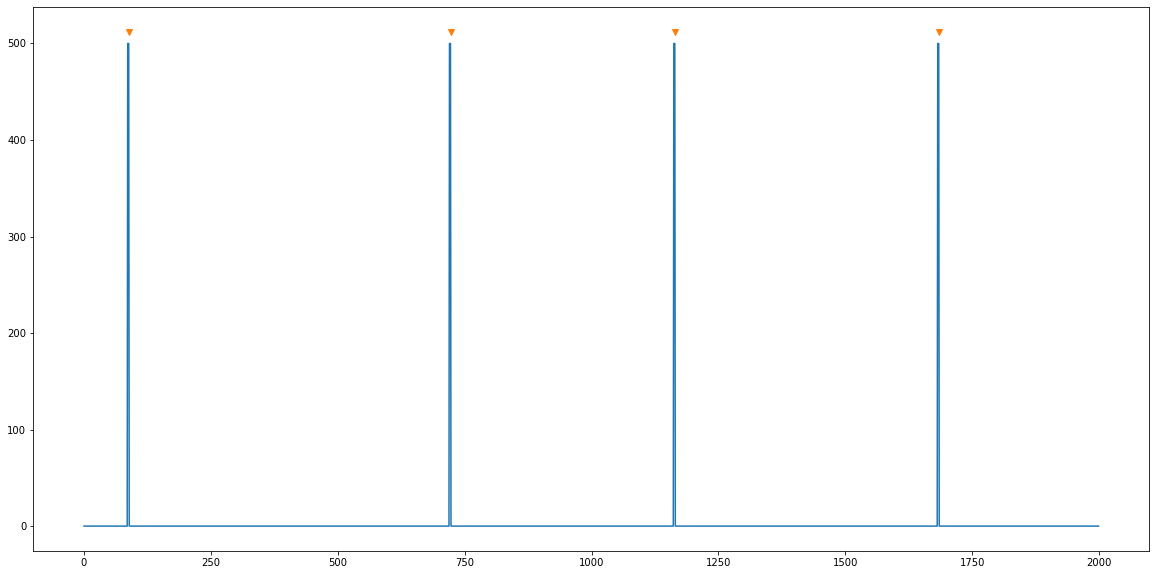

Accuracy for row  3  is  99.229 %


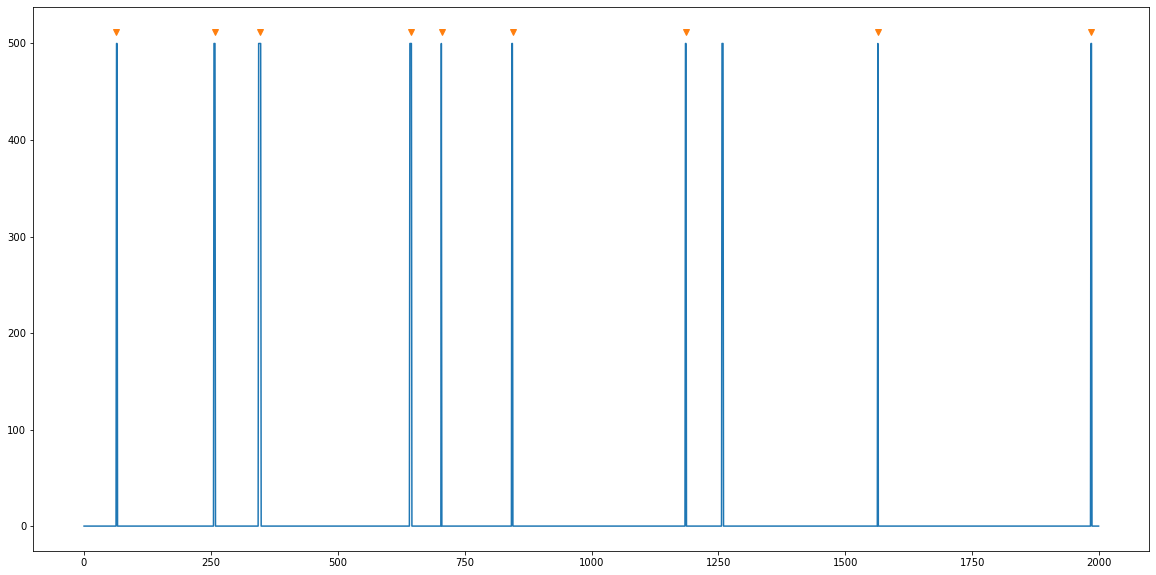

Accuracy for row  4  is  99.271 %


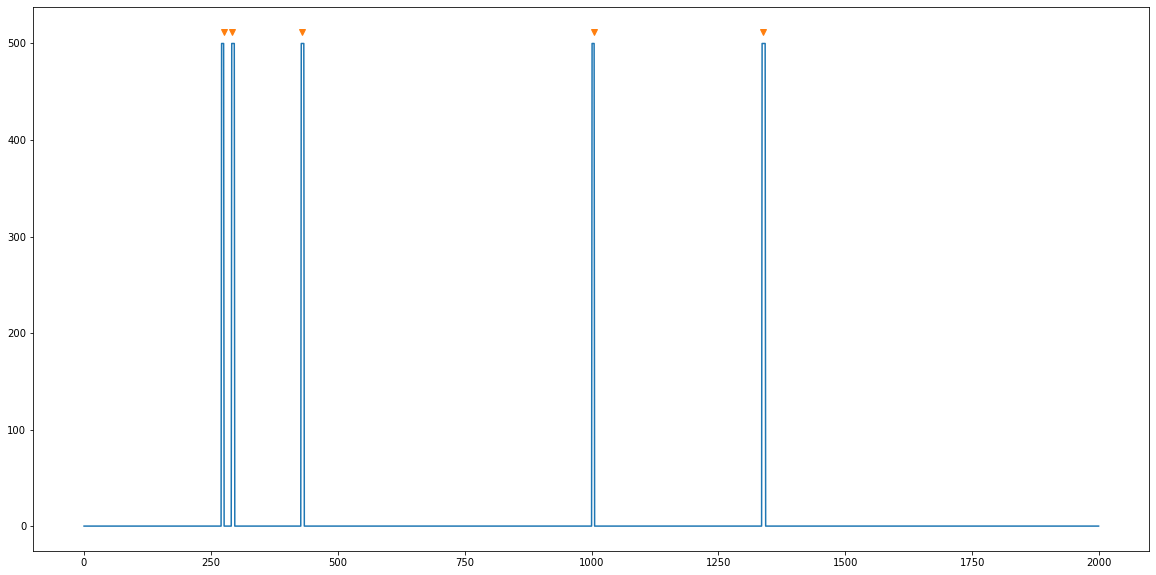

Accuracy for row  5  is  99.871 %


In [14]:
rows = [1, 2, 3, 4, 5]


for row_to_plot in rows:
    with open(csv_file, 'r') as f:
        original_data = f.read().split('\n')[1:]
        original_data = original_data[row_to_plot].split(',')
        spike_positions = [int(x) for x in original_data[1].split(';')]
        samples = [int(x) for x in original_data[0].split(';')]

    spikes = [math.nan] * len(samples)

    spike_y = max(samples) + 1

    for s in spike_positions:
        spikes[s] = spike_y
        
    t = [x/20000 for x in range(len(samples))]
    
    filtered = butter_bandpass_filter(samples, 450, 6000, 20000, order=8)
    
    N = 3.2
    
    mean = np.mean(filtered)
    spiked = np.zeros(len(filtered))
    sigma = np.median(np.abs(filtered-mean)/0.6745)
    spiked[filtered>N*sigma] = 1
    
    plt.plot(500*spiked[2000:4000])
    plt.plot(spikes[2000:4000], 'v')
    plt.show()
    
    indices_where_spikes_exist = np.where(np.array(spikes)>0)[0]
    
    indices_detected_with_spikes = np.where(spiked==1)[0]
#     print(indices_detected_with_spikes)
    not_detected = 0
    
#     print(len(indices_where_spikes_exist), len(indices_detected_with_spikes))
    
    for i in indices_where_spikes_exist:
        if i not in indices_detected_with_spikes:
            not_detected += 1
    print("Accuracy for row ", row_to_plot, " is ", np.round(100-(not_detected/len(indices_where_spikes_exist)), 3),"%")
#     print(not_detected)
    

#### This accuracy seems okay, so I move on to refining this algorithm for use in real time systems